In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy import special
from scipy.stats import chi2
from IPython.display import display, clear_output
from sklearn.neighbors import KernelDensity
from sklearn.cluster import estimate_bandwidth
from scipy.spatial.distance import jensenshannon
"""
Helper Functions
"""
def phi(x, mu, sigma):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + special.erf((x - mu) / (sigma * np.sqrt(2.0)))) / 2.0

def timer(fun, t, W):
    start_time = time.time()
    r = fun(t, W)
    t = time.time() - start_time
    print("--- %s seconds ---" % t)
    return t, r

def comb(n, r):
    return math.factorial(n) // math.factorial(r) // math.factorial(n-r)
    
def irwin_hall(x, n):
    s = 0
    for k in range(0, n + 1):
        s += ((-1)**k)*comb(n, k)*(x-k)**(n-1)*np.sign(x-k)
    return s/(2 * math.factorial(n - 1))
def irwin_hall_cdf(x, n):
    s = 0
    for k in range(0, n + 1):
        s += ((-1)**k)*comb(n, k)*(x-k)**(n)*np.sign(x-k)
    return s/(math.factorial(n))

def bates_pdf(low, high, x, n):
    y = (x - low) / (high - low)
    return irwin_hall(y, n)/(high - low)

def chi_square(x, k):
    return (x**(k/2 - 1)*np.exp(-x/2)) / (2**(k/2) * math.gamma(k/2))

#Find all solutions for subset sum problem.
#https://arxiv.org/pdf/1807.02611.pdf
def SubsetSum(t, W):
    sol = []
    
    i = 0
    T = np.array([t])
    while i<len(W):
        B=T-W[i]
        T = np.append(T, B)
        i += 1
    K = np.where(T == 0)[0]
    if len(K) > 0:
        i = 0
        while i<len(K):
            A = 2*(K[i])
            b = " ".join(bin(A).replace('0b', ''))
            b = b[0:len(b)-1]
            b_array = np.fromstring(b[::-1], dtype = int, sep = ' ')
            addon = np.zeros(len(W) - len(b_array))
            b_array = np.append(b_array, addon)
            
            s = b_array * W
            sol.append(s)
            i += 1
    return sol

def lenSubsetSum(t,W):
    return len(SubsetSum(t,W))

#Probabilistic Solution via normal approximation
def normal_pdf(t, mu_hat, sigma_hat):
    return 1/(sigma_hat * np.sqrt(2 * np.pi)) * np.exp( - (t - mu_hat)**2 / (2 * sigma_hat**2) )
def NormalSubsetSum(t, W):
    n = len(W)
    
    sigma = np.sqrt(np.var(W))
    mu = np.mean(W)
    
    s = 0
    
    for k in range(1, n+1):
        mu_hat = k * mu
        sigma_hat = np.sqrt(k*sigma**2*(1 - (k -1)/(n)))
        
        p = normal_pdf(t, mu_hat, sigma_hat)
        s += p * comb(n, k)
    return s

#Probabilistic Solution for alternate threshold problem via normal approximation CDF
def create_weights(N):
    total = 0
    weights = []
    for n in range(1, N+1):
        c = comb(N,n)
        weights.append(c)
        total += c
    return np.array(weights)/total
def NormalSubsetSumCDF(t, W):
    n = len(W)
    weights = create_weights(n)
    
    sigma = np.sqrt(np.var(W))
    mu = np.mean(W)
    
    s = []   
    for k in range(1, n+1):
        mu_hat = k * mu
        sigma_hat = np.sqrt(k*sigma**2*(1 - (k -1)/(n-1)))
        
        p = 1 - phi(t, mu_hat, sigma_hat)
        s.append(p)
        
    return sum(weights * s)
def Chi2SubsetSumCDF(t, df):
    weights = create_weights(n)
    
    s = []   
    for k in range(1, n+1):
        p = 1 - chi2.cdf(t, k * df)
        s.append(p)
        
    return sum(weights * s)
#Kernel's
def tophatkde(sample, h, t):
    n = len(sample)
    dif = np.abs(np.array(sample) - t)
    dif = dif <= h
    dif = dif * 1/(2 * h)
    return sum(1/(n) * dif)
def gausskde(sample, h, t):
    n = len(sample)
    dif = np.array(sample) - t
    return sum(1/(n * h * np.sqrt(2 * np.pi)) * np.exp( - dif**2 / (2 * h**2)))
def gausskde_predict(sample, h, x):
    predictions = []
    for t in x:
        predictions.append(gausskde(sample, h, t))
    return predictions
def KDESubsetSum(t, W, quantile=0.1, sample_size=1000, kde=tophatkde):
    weights = create_weights(n)
    n = len(W)
    s = 0
    
    for k in range(1, n):
        sample = []
        for i in range(sample_size):
            sample.append(sum(np.random.choice(W, k, replace=False)))
        bandwidth = estimate_bandwidth(np.array(sample).reshape(-1,1), quantile=quantile)
        p = kde(sample, bandwidth, t)
        s += p * comb(n, k)
    if sum(W) == t:
        s+=1
    return s
#Applications
def change_making(target, coins):
    ways = [1]+[0]*target
    for coin in coins:
        for i in range(coin,target+1):
            ways[i]+=ways[i-coin]
    return ways[target]

def plot_normal(n, x, sample):
    N = len(sample)
    mu = np.mean(sample)
    sigma = np.sqrt(np.var(sample))
    
    mu_hat = n * mu
    sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(N)))
    
    plt.plot(x, normal_pdf(x, mu_hat, sigma_hat))
def sample_sum(W):
    k = np.random.randint(1, len(W))
    return sum(np.random.choice(W, k, replace=False))

## Graphs/Tests

Normal Jensen-Shannon Divergence: 0.052871883100975
Irwin-Hall Jensen-Shannon Divergence: 0.03605181953138385


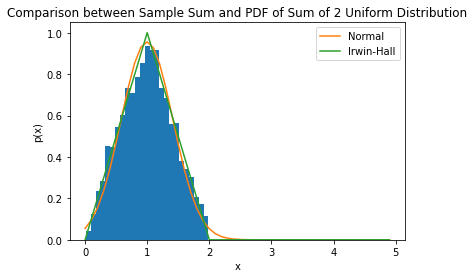

Normal Jensen-Shannon Divergence: 0.03450614517228972
Irwin-Hall Jensen-Shannon Divergence: 0.019820818273371222


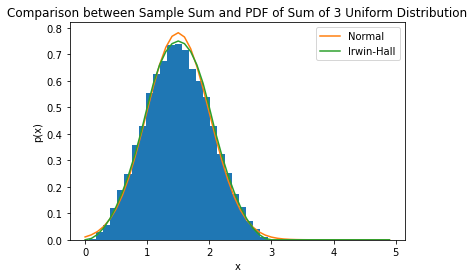

Normal Jensen-Shannon Divergence: 0.024134985147913252
Irwin-Hall Jensen-Shannon Divergence: 0.023364637494052903


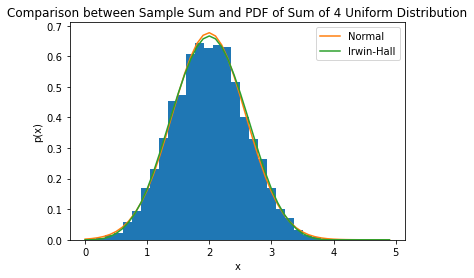

Normal Jensen-Shannon Divergence: 0.024730579328174646
Irwin-Hall Jensen-Shannon Divergence: 0.024516304003365148


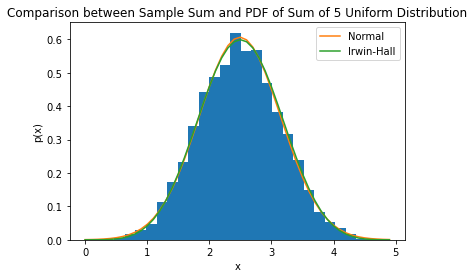

In [2]:
#Distribution Approximation Using Normal
x = np.arange(0,5, 0.1)
x_hat = np.random.uniform(0,1, 500)

sigma = np.sqrt(np.var(x_hat))
mu = np.mean(x_hat)

for n in range(2, 6):
    sample = []
    for i in range(10000):
        s = sum(np.random.choice(x_hat, n, replace=False))
        sample.append(s)
        
    mu_hat = n * mu
    sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(len(x_hat))))
    
    (X, bins, patches) = plt.hist(sample, density=True, bins=25)
    middle_bins = np.array([(bins[i]+bins[i+1])/2 for i in range(0, len(bins)-1, 1)])
    plt.plot(x, normal_pdf(x,mu_hat,sigma_hat))
    plt.title('Comparison between Sample Sum and PDF of Normal Approximation')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    print("Normal Jensen-Shannon Divergence: " + str(jensenshannon(X, normal_pdf(middle_bins, mu_hat, sigma_hat))))
    
    plt.plot(x, irwin_hall(x, n))
    plt.title('Comparison between Sample Sum and PDF of Sum of ' + str(n) + ' Uniform Distribution')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    print("Irwin-Hall Jensen-Shannon Divergence: " + str(jensenshannon(X, irwin_hall(middle_bins, n))))
    
    plt.legend(['Normal', 'Irwin-Hall'])
    plt.show()

In [3]:
test = [1, 8, 7, 2 , 9, 9, 5, 4, 3]
a = SubsetSum(9, test)

answer = [np.array([1., 8., 0., 0., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 7., 2., 0., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 9., 0., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 9., 0., 0., 0.]),
 np.array([0., 0., 0., 0., 0., 0., 5., 4., 0.]),
 np.array([1., 0., 0., 0., 0., 0., 5., 0., 3.]),
 np.array([0., 0., 0., 2., 0., 0., 0., 4., 3.])]

np.allclose(answer, a)

True

In [4]:
simtest = np.random.uniform(low=0.0, high=100, size=26)

In [5]:
timer(lenSubsetSum, 9, simtest)

--- 0.8290019035339355 seconds ---


(0.8290019035339355, 0)

## Simulations

## -------------------------------------------------------------------------------------------------------

### Discrete Uniform Set S

Normal Jensen-Shannon Divergence: 0.12472025473499955
Irwin-Hall Jensen-Shannon Divergence: 0.2288638763455299


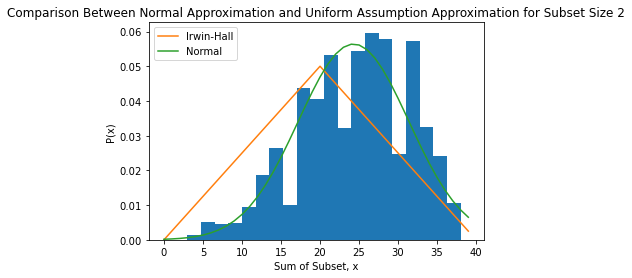

Normal Jensen-Shannon Divergence: 0.08363090148995157
Irwin-Hall Jensen-Shannon Divergence: 0.24996175562583536


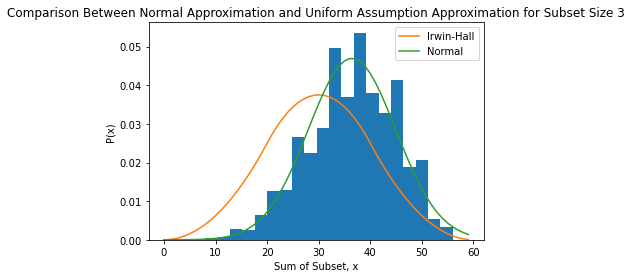

Normal Jensen-Shannon Divergence: 0.04254151243308186
Irwin-Hall Jensen-Shannon Divergence: 0.2748265818107307


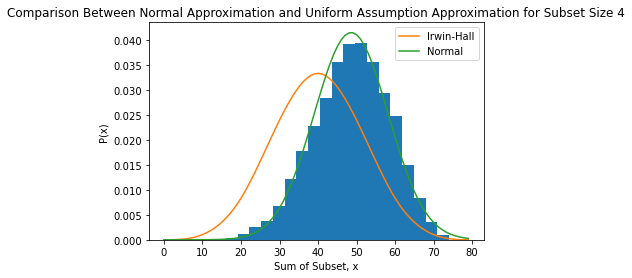

Normal Jensen-Shannon Divergence: 0.06489516799893048
Irwin-Hall Jensen-Shannon Divergence: 0.3147236999622003


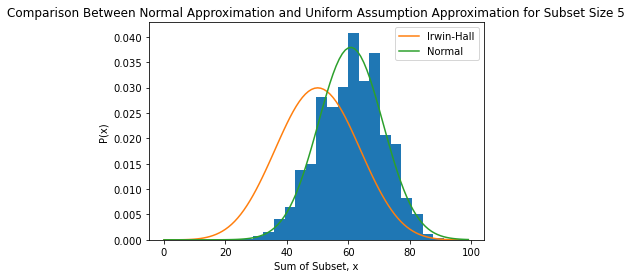

In [6]:
#Plotting a few samples
low = 0
high = 20
N = 27
sim = np.random.randint(low=low, high=high, size=N)

sigma = np.sqrt(np.var(sim))
mu = np.mean(sim)

for n in range(2, 6):
    sums = []
    for i in range(20000):
        
        mu_hat = n * mu
        sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(N)))
        
        s = sum(np.random.choice(sim, n, replace=False))
        sums.append(s)
    (X, bins, patches) = plt.hist(sums, density=True, bins=20)
    middle_bins = np.array([(bins[i]+bins[i+1])/2 for i in range(0, len(bins)-1, 1)])

    x = np.arange(0, n * high)
    plt.plot(x, bates_pdf(low, high, x, n))
    plt.plot(x, normal_pdf(x, mu_hat, sigma_hat))
    
    plt.title('Comparison Between Normal Approximation and Uniform Assumption Approximation for Subset Size ' + str(n))
    plt.xlabel('Sum of Subset, x')
    plt.ylabel('P(x)')
    plt.legend(['Irwin-Hall', 'Normal'])
    print("Normal Jensen-Shannon Divergence: " + str(jensenshannon(X, normal_pdf(middle_bins, mu_hat, sigma_hat))))
    print("Irwin-Hall Jensen-Shannon Divergence: " + str(jensenshannon(X, bates_pdf(low, high, middle_bins, n))))
    plt.show()

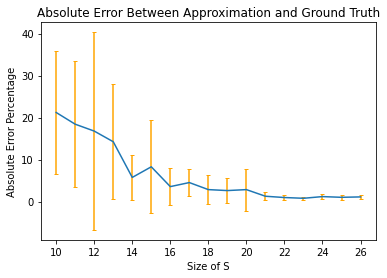

In [11]:
low = 0
high = 20
t = 60
r = 20
differences = np.array([])
for i in range(r):
    truths = []
    normal_approxs = []

    for N in range(10, 27):
        scaled = int(N/27 * t)
        
        sim = np.random.randint(low=low, high=high, size=N)
        truths.append(lenSubsetSum(scaled, sim))
        normal_approxs.append(NormalSubsetSum(scaled, sim))

    normal_approxs = np.array(normal_approxs).astype(int)
    if len(differences) == 0:
        differences = (100 * np.abs(truths - normal_approxs)/truths).reshape(-1,1)
    else:
        differences = np.hstack([differences, (100 * np.abs(truths - normal_approxs)/truths).reshape(-1,1)])
differences_sd = np.std(differences, axis=1)
differences = np.mean(differences, axis=1)
x = np.arange(10, 27)
plt.errorbar(x, differences, yerr=differences_sd, capsize=2, ecolor='orange')
plt.xlabel('Size of S')
plt.ylabel('Absolute Error Percentage')
plt.title('Absolute Error Between Approximation and Ground Truth')
if i == int(r/2):
    print('Halfway there...')
plt.show()

## -------------------------------------------------------------------------------------------------------

### Chi Square Continuous Sample Set S

Normal Jensen-Shannon Divergence: 0.08744549489640248
Chi-Square Jensen-Shannon Divergence: 0.02684100140095264


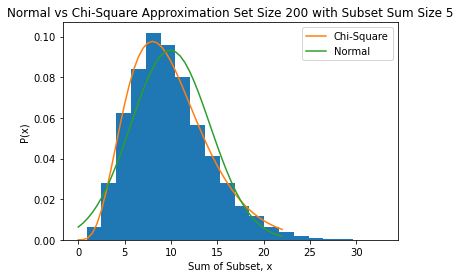

Normal Jensen-Shannon Divergence: 0.0714936714811681
Chi-Square Jensen-Shannon Divergence: 0.02725032758320747


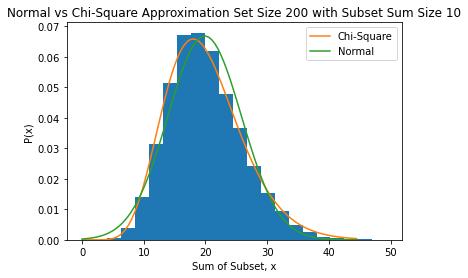

Normal Jensen-Shannon Divergence: 0.043005592656002914
Chi-Square Jensen-Shannon Divergence: 0.0479297736392375


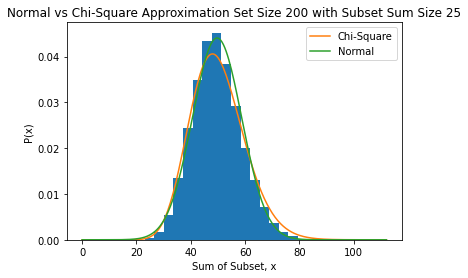

Normal Jensen-Shannon Divergence: 0.02215777714119231
Chi-Square Jensen-Shannon Divergence: 0.07943514982834599


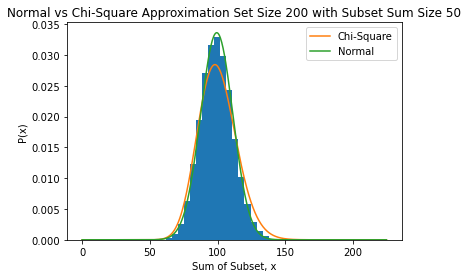

Normal Jensen-Shannon Divergence: 0.01185508982858158
Chi-Square Jensen-Shannon Divergence: 0.16842985896981735


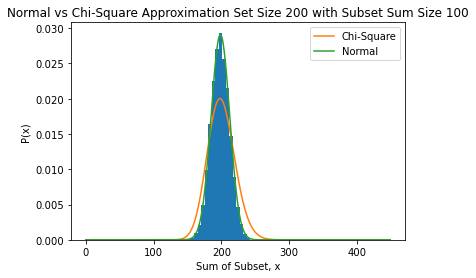

In [8]:
#Plotting a few samples
df = 2
N = 200
sim = np.random.chisquare(df, size=N)

sigma = np.sqrt(np.var(sim))
mu = np.mean(sim)

for n in [5, 10, 25, 50, 100]:
    sums = []
    for i in range(20000):
        
        mu_hat = n * mu
        sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(N)))
        
        s = sum(np.random.choice(sim, n, replace=False))
        sums.append(s)
    (X, bins, patches) = plt.hist(sums, density=True, bins=20)
    middle_bins = np.array([(bins[i]+bins[i+1])/2 for i in range(0, len(bins)-1, 1)])
    x = np.arange(0, n * 4.5, 0.5)
    plt.plot(x, chi_square(x, n * df))
    plt.plot(x, normal_pdf(x, mu_hat, sigma_hat))
    
    plt.title('Normal vs Chi-Square Approximation Set Size ' + str(N)+ ' with Subset Sum Size ' + str(n))
    plt.xlabel('Sum of Subset, x')
    plt.ylabel('P(x)')
    plt.legend(['Chi-Square', 'Normal'])
    
    print("Normal Jensen-Shannon Divergence: " + str(jensenshannon(X, normal_pdf(middle_bins, mu_hat, sigma_hat))))
    print("Chi-Square Jensen-Shannon Divergence: " + str(jensenshannon(X, chi_square(middle_bins, mu_hat))))
    plt.show()

Normal Jensen-Shannon Divergence: 0.09781730508462351
Chi-Square Jensen-Shannon Divergence: 0.018386887144620716


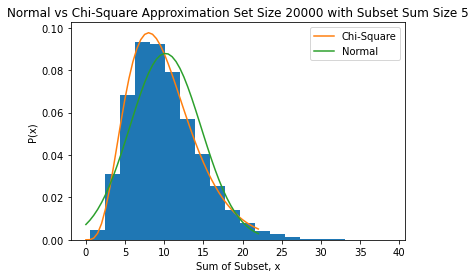

Normal Jensen-Shannon Divergence: 0.07810351608098746
Chi-Square Jensen-Shannon Divergence: 0.014662763889940136


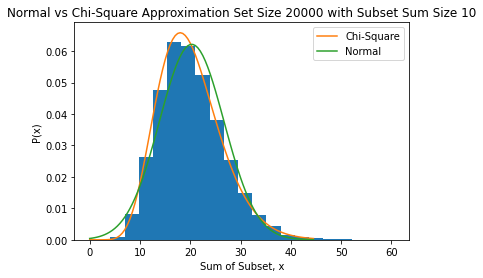

Normal Jensen-Shannon Divergence: 0.05183443727281398
Chi-Square Jensen-Shannon Divergence: 0.011470426681439523


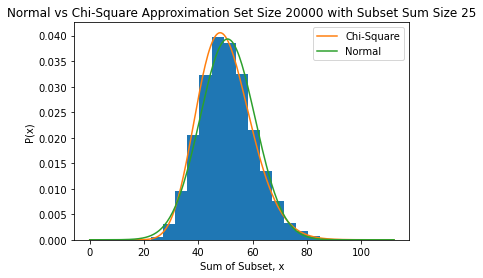

Normal Jensen-Shannon Divergence: 0.041129385726145835
Chi-Square Jensen-Shannon Divergence: 0.012722707964599208


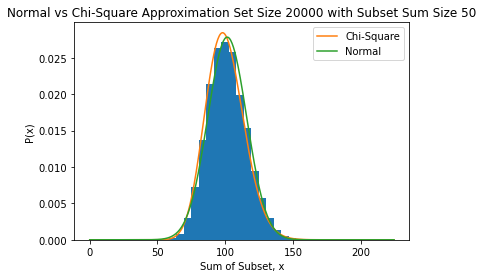

Normal Jensen-Shannon Divergence: 0.03178988037918919
Chi-Square Jensen-Shannon Divergence: 0.012352001995089179


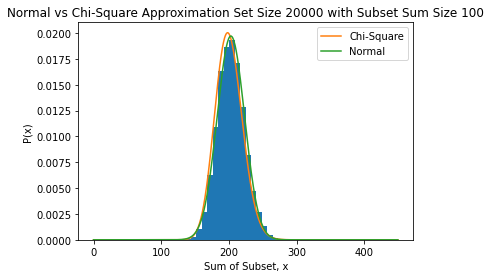

In [9]:
#Plotting a few samples
df = 2
N = 20000
sim = np.random.chisquare(df, size=N)

sigma = np.sqrt(np.var(sim))
mu = np.mean(sim)

for n in [5, 10, 25, 50, 100]:
    sums = []
    for i in range(N):
        
        mu_hat = n * mu
        sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(N)))
        
        s = sum(np.random.choice(sim, n, replace=False))
        sums.append(s)
    (X, bins, patches) = plt.hist(sums, density=True, bins=20)
    middle_bins = np.array([(bins[i]+bins[i+1])/2 for i in range(0, len(bins)-1, 1)])
    x = np.arange(0, n * 4.5, 0.5)
    plt.plot(x, chi_square(x, n * df))
    plt.plot(x, normal_pdf(x, mu_hat, sigma_hat))
    
    plt.title('Normal vs Chi-Square Approximation Set Size ' + str(N)+ ' with Subset Sum Size ' + str(n))
    plt.xlabel('Sum of Subset, x')
    plt.ylabel('P(x)')
    plt.legend(['Chi-Square', 'Normal'])
    
    print("Normal Jensen-Shannon Divergence: " + str(jensenshannon(X, normal_pdf(middle_bins, mu_hat, sigma_hat))))
    print("Chi-Square Jensen-Shannon Divergence: " + str(jensenshannon(X, chi_square(middle_bins, mu_hat))))
    plt.show()

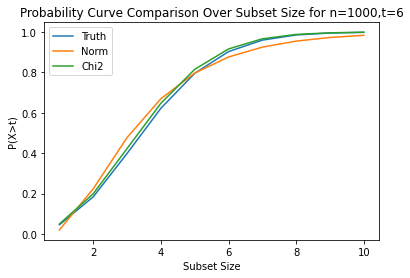

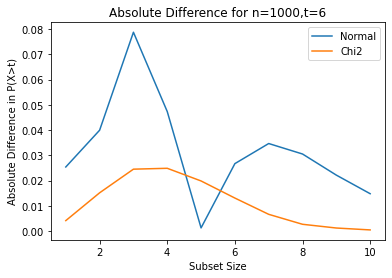

In [33]:
df = 2
N = 1000
t = 6
r = 10
sample=100

sim = np.random.chisquare(df, size=N)

sigma = np.sqrt(np.var(sim))
mu = np.mean(sim)

approx = 0


sa = []
sc = []
st = []
norm_dif = []
chi_dif = []
#Random sampling to simulate probability of sum > t

for n in range(1, 11):
    pc = []
    p = []
    sim_p = []
    for s in range(sample):
        total = 0
        truth = 0
        for i in range(5000):
            s = sum(np.random.choice(sim, n, replace=False))
            total += 1
            if s > t:
                truth += 1

        mu_hat = n * mu
        sigma_hat = np.sqrt(n*sigma**2*(1 - (n -1)/(N)))

        p.append(1 - phi(t, mu_hat, sigma_hat))
        
        pc.append(1 - chi2.cdf(t, n * df))

        sim_p.append(truth/total)
    p_mean = np.mean(p)
    pc_mean = np.mean(pc)
    sim_p_mean = np.mean(sim_p)
    norm_difference = np.abs(p_mean - sim_p_mean)
    chi_difference = np.abs(pc_mean - sim_p_mean)
    st.append(sim_p_mean)
    sc.append(pc_mean)
    sa.append(p_mean)

        
    norm_dif.append(norm_difference)

    chi_dif.append(chi_difference)

x = np.arange(1, N + 1)
cutoff = int(10)
#Comparison
plt.plot(x[:cutoff], st[:cutoff])
plt.plot(x[:cutoff], sa[:cutoff])
plt.plot(x[:cutoff], sc[:cutoff])
plt.legend(['Truth','Norm', 'Chi2'])
plt.title('Probability Curve Comparison Over Subset Size for n=' + str(N) + ',t=' + str(t))
plt.ylabel('P(X>t)')
plt.xlabel('Subset Size')
plt.show()
#Difference
plt.plot(x[:cutoff], norm_dif[:cutoff])
plt.plot(x[:cutoff], chi_dif[:cutoff])
plt.title('Absolute Difference for n=' + str(N) + ',t=' + str(t))
plt.ylabel('Absolute Difference in P(X>t)')
plt.xlabel('Subset Size')
plt.legend(['Normal','Chi2'])
plt.show()

'N=50'

'1/15...'

'2/15...'

'3/15...'

'4/15...'

'5/15...'

'6/15...'

'7/15...'

'8/15...'

'9/15...'

'10/15...'

'11/15...'

'12/15...'

'13/15...'

'14/15...'

'15/15...'

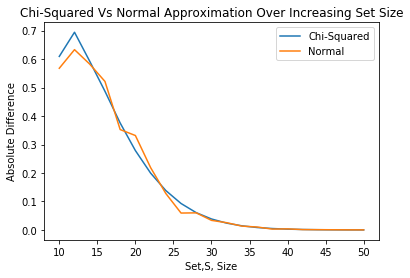

In [933]:
r = 15
df = 2
t=15

low = 10
high = 51
step = 2

norm_dif = []
chi2_dif = []
for N in range(low, high, step):
    clear_output(wait=True)
    display('N='+str(N))
    
    chi2_avg = []
    norm_avg = []
    for i in range(r):
        display(str(i+1)+'/'+str(r)+'...')
        sim = np.random.chisquare(df, size=N)

        sigma = np.sqrt(np.var(sim))
        mu = np.mean(sim)
        for n in range(1, N + 1):
            sims = []
            total = 0
            truth = 0
            for i in range(1000):
                s = sum(np.random.choice(sim, n, replace=False))
                total += 1
                if s > t:
                    truth += 1
            sim_p = truth/total
            sims.append(sim_p)
        sim_app = sum(create_weights(N) * sim_p)
        norm_app = NormalSubsetSumCDF(t, sim)
        chi2_app = Chi2SubsetSumCDF(t, df)
        
        norm_avg.append(np.abs(norm_app - sim_app))
        chi2_avg.append(np.abs(chi2_app - sim_app))
    chi2_dif.append(np.mean(chi2_avg))
    norm_dif.append(np.mean(norm_avg))
    
x = np.arange(low, high, step)
plt.plot(x, chi2_dif)
plt.plot(x, norm_dif)

plt.title('Chi-Squared Vs Normal Approximation Over Increasing Set Size')
plt.xlabel('Set,S, Size')
plt.ylabel('Absolute Difference')
plt.legend(['Chi-Squared', 'Normal'])
plt.show()

## -------------------------------------------------------------------------------------------------------

## Change-Making Problem

Normal Jensen-Shannon Divergence: 0.798111901986562
KDE Jensen-Shannon Divergence: 0.2792297575747266


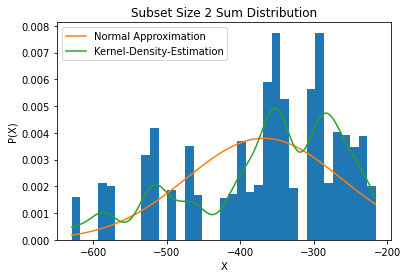

Normal Jensen-Shannon Divergence: 0.8240909192133671
KDE Jensen-Shannon Divergence: 0.10889758954342878


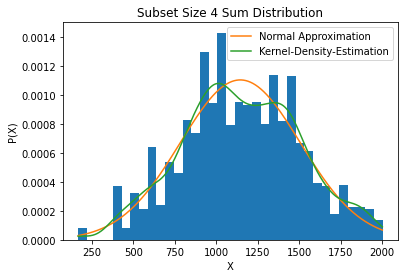

Normal Jensen-Shannon Divergence: 0.7998527954226436
KDE Jensen-Shannon Divergence: 0.13562757247841897


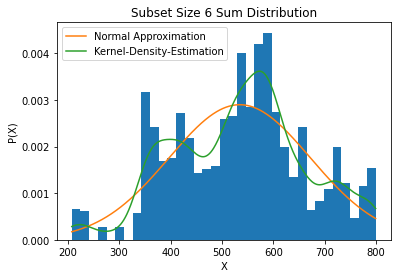

Normal Jensen-Shannon Divergence: 0.7863510724835926
KDE Jensen-Shannon Divergence: 0.23209549235584656


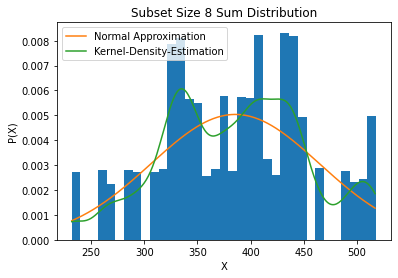

In [111]:
for t in [2,4,6,8]:
    for n in [10]:
        coins = []
        x = 0
        for i in range(n):
            x = int(np.random.normal(x,100, 1)[0])
            coins.append(x)
        
        #sampling without replacement
        sample = []
        for i in range(5000):
            s = sum(np.random.choice(coins, t, replace=False))
            sample.append(s)
        x = np.arange(np.min(sample), np.max(sample) , 1)
        #kde
        bandwidth = estimate_bandwidth(np.array(sample).reshape(-1,1), quantile=0.09)
        kde_val = gausskde_predict(sample, bandwidth, x)
        #plot
        (X, bins, patches) = plt.hist(sample, density=True,bins=35)
        middle_bins = np.array([(bins[i]+bins[i+1])/2 for i in range(0, len(bins)-1, 1)])
        plot_normal(t, x, coins)
        plt.plot(x, kde_val)
        plt.legend(['Normal Approximation', 'Kernel-Density-Estimation'])
        plt.title('Subset Size '+ str(t) + ' Sum Distribution' )
        plt.xlabel('X')
        plt.ylabel('P(X)')
        
        print("Normal Jensen-Shannon Divergence: " + str(jensenshannon(X, normal_pdf(middle_bins, mu_hat, sigma_hat))))
        print("KDE Jensen-Shannon Divergence: " + str(jensenshannon(X, gausskde_predict(sample, bandwidth, middle_bins))))
        plt.show()